In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import os
import random

In [2]:
# local directory of images
file_dir = '../XN_Files/'

In each category, there are four images of the same brain. Each one of them has a different view/resolution that we can use to determine the class of hemhorrage.

../XN_Files/epidural/brain_bone_window/ID_0a3f30540.jpg


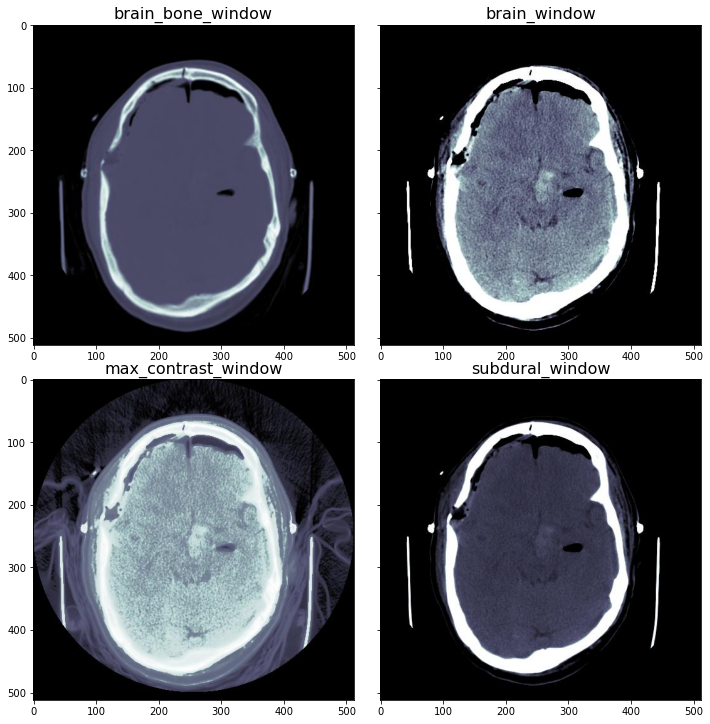

In [3]:
epidural = 'epidural/'
brain_bone = 'brain_bone_window'
brain_w = 'brain_window'
max_con = 'max_contrast_window'
subdural = 'subdural_window'

image_types = [(brain_bone, 0), (brain_w, 1), (max_con, 2), (subdural, 3)]

images = [mpimg.imread(file_dir + epidural + brain_bone + '/ID_0a3f30540.jpg'),
          mpimg.imread(file_dir + epidural +  brain_w + '/ID_0a3f30540.jpg'),
          mpimg.imread(file_dir + epidural +  max_con + '/ID_0a3f30540.jpg'),
         mpimg.imread(file_dir + epidural +  subdural + '/ID_0a3f30540.jpg')]

print(file_dir + epidural + brain_bone + '/ID_0a3f30540.jpg')

f, axes = plt.subplots(2, 2, sharey = True)
f.set_size_inches(10,10)
f.tight_layout()

axes = axes.reshape(4)

for i, j in zip(images, image_types):
    axes[j[1]].imshow(i)
    axes[j[1]].set_title(j[0], fontsize=16)


### Loading and Cleaning the Segmentation Files

In [4]:
#### Rename files for easiser processing -> ex. epidural.csv ###

In [5]:
# local directory of images
file_dir = '../XN_Files/'


#image types
brain_bone = 'brain_bone_window'
brain_w = 'brain_window'
max_con = 'max_contrast_window'
subdural = 'subdural_window'


#image size
im_size = 512*512

In [6]:
def convert_coordinates(coords):
    result = []
    for coord in eval(coords):
        result.append((np.array([[pair['x'], pair['y']] for pair in coord]) * 512).astype(int))
    return result

In [7]:
def load_labels(f_dir: str, image_type: str) -> pd.DataFrame:
    """Function to get hemmorhage labels. Method prerequisite: rename result csv files to match type_labels dict -> ex. epidural.csv, multi.csv"""
    # set class designations and relevant columns
    type_labels = {'epidural': 1, 'intraparenchymal': 2, 'subarachnoid': 3, 'subdural': 4, 'multi': 5,}
    column_names = ["Origin","Labeling State","All Labels","Majority Label", "Correct Label"]
    labels = pd.DataFrame()
    
    # for each hemorrhage type, load label data
    for k,v in type_labels.items():
        temp_data = pd.read_csv(file_dir + './Hemorrhage Segmentation Project/' + k + '.csv', low_memory=False)
        temp_data = temp_data[column_names]
        temp_data['Hemorrhage Type'] = k
        temp_data['Class'] = v
        labels = pd.concat([labels, temp_data])
        
    # drop all rows that are not labeled
    labeled = labels[labels['Labeling State']=='Labeled']
    gold = labels[labels['Labeling State']=='Gold Standard']
    labeled_df = pd.concat([labeled, gold]).dropna().reset_index().drop(['index'],axis = 1)
    

    
    # filter labeled images - only take images which hold correct labels
    labeled_df['Correct_Present'] = labeled_df['Correct Label'].apply(lambda x: 1 if "x" in x else 0)    
    labeled_df = labeled_df[labeled_df.Correct_Present==1].reset_index().drop(['index','Correct_Present'],axis = 1)
    
    
    # drop duplicates
    labeled_df = labeled_df.drop_duplicates(subset=['Origin']).reset_index().drop(['index'],axis = 1)
    
    # drop images with il-formatted coordinates
    labeled_df = labeled_df[labeled_df.Origin!='ID_6168d766c.jpg']
    labeled_df = labeled_df[labeled_df.Origin!='ID_1e643d438.jpg']
    labeled_df = labeled_df[labeled_df.Origin!='ID_233344b54.jpg']
    labeled_df = labeled_df[labeled_df.Origin!='ID_a39f8e984.jpg']
    labeled_df = labeled_df[labeled_df.Origin!='ID_acef57288.jpg']
    
    
    # convert coordinates for opencv use
    labeled_df["X-Y_segment"] = labeled_df['Correct Label'].apply(convert_coordinates)

    
    # add normal sample
    normal_sample_size = 500
    normal_images = os.listdir(file_dir + 'normal/' + image_type + '/')
    random.seed(123)
    normal_sample = random.sample(normal_images, k=normal_sample_size)
    norm_df = pd.DataFrame(normal_sample, columns=['Origin'])
    norm_df = norm_df.assign(**{ x : 'NA' for x in column_names[1:] })
    norm_df['Hemorrhage Type'] = 'normal'
    norm_df['Class'] = 6
    
    # final df
    final_labels = pd.concat([labeled_df, norm_df]).reset_index().drop(['index','All Labels','Majority Label'],axis = 1)
    final_labels['Image Type'] = image_type
    
    
    
    return final_labels

In [8]:
def load_data_per_image_type(file_dir: str, labels: pd.DataFrame, im_size: int) -> np.array([]):
    data = np.zeros([labels.shape[0], im_size])
    y = np.zeros([labels.shape[0],]).astype(int)
    print(f'Data Shape: {data.shape}', f'Label Shape: {y.shape}')
    for index, row in labels.iterrows():
        try:
            data[index,:] = np.mean(mpimg.imread(file_dir + row['Hemorrhage Type'] +'/'+ row['Image Type'] + '/' + row['Origin']), axis=2).reshape(-1)
            y[index] = row['Class']
        except Exception as e:
            print(f"Image {row['Origin']} is an incompatible size, skipping")
            continue   
    return data, y

#### Load data for max contrast window


In [9]:
# max_contrast_window
labels = load_labels(file_dir, max_con)
X, y = load_data_per_image_type(file_dir, labels, im_size)
labels

Data Shape: (1842, 262144) Label Shape: (1842,)
Image ID_88b0d8b4f.jpg is an incompatible size, skipping


,Origin,Labeling State,Correct Label,Hemorrhage Type,Class,X-Y_segment,Image Type
0,ID_004c4b319.jpg,Labeled,"[[{'x': 0.537109375, 'y': 0.89453125}, {'x': 0...",epidural,1,"[[[275, 458], [275, 457], [274, 457], [271, 45...",max_contrast_window
1,ID_02e2d273d.jpg,Labeled,"[[{'x': 0.46484375, 'y': 0.357421875}, {'x': 0...",epidural,1,"[[[238, 183], [238, 182], [237, 182], [229, 18...",max_contrast_window
2,ID_03c6a01ca.jpg,Labeled,"[[{'x': 0.55078125, 'y': 0.7265625}, {'x': 0.5...",epidural,1,"[[[282, 372], [282, 371], [281, 371], [280, 37...",max_contrast_window
3,ID_045196c9f.jpg,Labeled,"[[{'x': 0.591796875, 'y': 0.791015625}, {'x': ...",epidural,1,"[[[303, 405], [303, 401], [304, 401], [304, 39...",max_contrast_window
4,ID_0513bfa29.jpg,Labeled,"[[{'x': 0.78125, 'y': 0.6875}, {'x': 0.78125, ...",epidural,1,"[[[400, 352], [400, 344], [399, 344], [399, 34...",max_contrast_window
...,...,...,...,...,...,...,...
1837,ID_008bbcbc7.jpg,NA,NA,normal,6,NaN,max_contrast_window
1838,ID_002e03abf.jpg,NA,NA,normal,6,NaN,max_contrast_window
1839,ID_029747d7b.jpg,NA,NA,normal,6,NaN,max_contrast_window
1840,ID_0184b24fa.jpg,NA,NA,normal,6,NaN,max_contrast_window


In [10]:
# In case we want to examine the data manually
# labels.to_excel("data.xlsx", index = False)

**Analysis Setup**

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
# import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [12]:
# train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
print(f'Train Data Shape -> X: {X_train.shape}, y: {y_train.shape}')
print(f'Test Data Shape -> X: {X_test.shape}, y: {y_test.shape}')

Train Data Shape -> X: (1565, 262144), y: (1565,)
Test Data Shape -> X: (277, 262144), y: (277,)


**Logistic Regression**

In [ ]:
# tune our hyperparamters
param_grid = { 'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'max_iter': [1, 10, 50, 100] }

lr = LogisticRegression(solver='lbfgs')

grid_search = GridSearchCV(lr, param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

print(f'Best Hyperparameters: {grid_search.best_params_}')


In [ ]:
og_clf = LogisticRegression(solver='lbfgs', max_iter=100)
og_clf.fit(X_train, y_train)
print("Logistic Regression Score: %.3f"%og_clf.score(X_test, y_test))

In [ ]:
y_pred = og_clf.predict(X_test)

In [ ]:
f1_score(y_test, y_pred, average='micro')

In [ ]:
optimized_clf = LogisticRegression(solver='lbfgs', max_iter=1, C=0.001)
optimized_clf.fit(X_train, y_train)
print("Logistic Regression Score: %.3f"%optimized_clf.score(X_test, y_test))

In [ ]:
y_pred = optimized_clf.predict(X_test)

In [ ]:
f1_score(y_test, y_pred, average='micro')

**Confusion matrix - Original**

In [ ]:
pred = og_clf.predict(X_test.reshape(-1, 262144))
print(pred[:5])

In [ ]:
from sklearn.metrics import confusion_matrix

pred = og_clf.predict(X_test.reshape(-1, 262144))

conf_mx = confusion_matrix(y_test, pred)
conf_mx

In [ ]:
import seaborn as sns

row_sum = conf_mx.sum(axis=1, keepdims=True)
nconf_mx = conf_mx/row_sum
np.fill_diagonal(nconf_mx,0)

sns.heatmap(nconf_mx)

***Confusion matrix - 'Opitimized'***

In [ ]:
pred = optimized_clf.predict(X_test.reshape(-1, 262144))
print(pred[:5])

In [ ]:
from sklearn.metrics import confusion_matrix

pred = optimized_clf.predict(X_test.reshape(-1, 262144))

conf_mx = confusion_matrix(y_test, pred)
conf_mx

In [ ]:
import seaborn as sns

row_sum = conf_mx.sum(axis=1, keepdims=True)
nconf_mx = conf_mx/row_sum
np.fill_diagonal(nconf_mx,0)

sns.heatmap(nconf_mx)

**LDA**

In [ ]:
lda = LinearDiscriminantAnalysis(store_covariance=False)
lda.fit(X_train, y_train)
print("LDA Score: %.3f"%lda.score(X_test, y_test))

In [ ]:
y_pred = lda.predict(X_test)

In [ ]:
f1_score(y_test, y_pred, average='micro')

**Random Forest**

In [ ]:
# Instantiate random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=0)

# Fit model on training data
rf.fit(X_train, y_train)

# Make predictions on testing data
y_pred = rf.predict(X_test)

# Evaluate model accuracy
accuracy = rf.score(X_test, y_test)
print(f"Model accuracy: {accuracy}")

In [ ]:
# tune our hyperparameters

# Instantiate random forest classifier
rf = RandomForestClassifier(random_state=0)

# Define hyperparameters for grid search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3]
}

In [ ]:
# Instantiate grid search with 2-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=2)

# Fit grid search on training data
grid_search.fit(X_train, y_train)

# Get best hyperparameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print results
print(f"Best hyperparameters: {best_params}")
print(f"Best score: {best_score}")

In [ ]:
# from sklearn.model_selection import cross_val_score, StratifiedKFold

# # Instantiate random forest classifier
# rf = RandomForestClassifier(random_state=0)

# # Define number of folds for stratified k-fold cross-validation
# n_splits = 2

# # Instantiate stratified k-fold cross-validation object
# skf = StratifiedKFold(n_splits=n_splits)

# # Compute cross-validation scores
# cv_scores = cross_val_score(rf, X, y, cv=skf)

# # Print results
# print(f"Cross-validation scores: {cv_scores}")
# print(f"Mean score: {cv_scores.mean()}")

In [ ]:
# run with best params

# Instantiate random forest classifier
rf = RandomForestClassifier(n_estimators=150, random_state=0, max_depth=15, min_samples_leaf=2, min_samples_split=5)

# Fit model on training data
rf.fit(X_train, y_train)

# Make predictions on testing data
y_pred = rf.predict(X_test)

# Evaluate model accuracy
accuracy = rf.score(X_test, y_test)
print(f"Model accuracy: {accuracy}")

In [ ]:
f1_score(y_test, y_pred, average='micro')

**XGBoost**

In [ ]:
# set up XGBoost classifier
clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=42)

# train the classifier on the training data
clf.fit(X_train, y_train)

# make predictions on the test data
y_pred = clf.predict(X_test)

# evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%%' % (accuracy * 100.0))

In [ ]:
# tune our hyperparameters

# Instantiate random forest classifier
clf = xgb.XGBClassifier(objective='binary:logistic', nthread=4, seed=42)

# Define hyperparameters for grid search
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [ ]:
# Instantiate grid search with 2-fold cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=2)

# Fit grid search on training data
grid_search.fit(X_train, y_train)

# Get best hyperparameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print results
print(f"Best hyperparameters: {best_params}")
print(f"Best score: {best_score}")

In [ ]:
# run with best params

# set up XGBoost classifier
clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=42)

# train the classifier on the training data
clf.fit(X_train, y_train)

# make predictions on the test data
y_pred = clf.predict(X_test)

# evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%%' % (accuracy * 100.0))

In [ ]:
!pip install opencv-python

## Segmentation


In [13]:
from collections import Counter
import ast
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import os
os.environ['QT_BACKEND'] = 'osx'
import cv2

In [14]:
labels = load_labels(file_dir, max_con)
X, y = load_data_per_image_type(file_dir, labels, im_size)
labels.to_csv("segment.csv", index = False)

Data Shape: (1842, 262144) Label Shape: (1842,)
Image ID_88b0d8b4f.jpg is an incompatible size, skipping


In [15]:
labels = pd.read_csv('segment.csv')

In [16]:
labels


,Origin,Labeling State,Correct Label,Hemorrhage Type,Class,X-Y_segment,Image Type
0,ID_004c4b319.jpg,Labeled,"[[{'x': 0.537109375, 'y': 0.89453125}, {'x': 0...",epidural,1,"[array([[275, 458],\n [275, 457],\n ...",max_contrast_window
1,ID_02e2d273d.jpg,Labeled,"[[{'x': 0.46484375, 'y': 0.357421875}, {'x': 0...",epidural,1,"[array([[238, 183],\n [238, 182],\n ...",max_contrast_window
2,ID_03c6a01ca.jpg,Labeled,"[[{'x': 0.55078125, 'y': 0.7265625}, {'x': 0.5...",epidural,1,"[array([[282, 372],\n [282, 371],\n ...",max_contrast_window
3,ID_045196c9f.jpg,Labeled,"[[{'x': 0.591796875, 'y': 0.791015625}, {'x': ...",epidural,1,"[array([[303, 405],\n [303, 401],\n ...",max_contrast_window
4,ID_0513bfa29.jpg,Labeled,"[[{'x': 0.78125, 'y': 0.6875}, {'x': 0.78125, ...",epidural,1,"[array([[400, 352],\n [400, 344],\n ...",max_contrast_window
...,...,...,...,...,...,...,...
1837,ID_008bbcbc7.jpg,NaN,NaN,normal,6,NaN,max_contrast_window
1838,ID_002e03abf.jpg,NaN,NaN,normal,6,NaN,max_contrast_window
1839,ID_029747d7b.jpg,NaN,NaN,normal,6,NaN,max_contrast_window
1840,ID_0184b24fa.jpg,NaN,NaN,normal,6,NaN,max_contrast_window


In [20]:
def create_mask(index):
    """ method that takes index and returns mask as a nested lists of coordinates """ 
    
    img_id = labels.iloc[index]['Origin']
    st = labels.iloc[index]['Correct Label']
    coords = ast.literal_eval(st)
    
    # empty mask to fill in
    
    img = np.zeros((512, 512), dtype=np.uint8)

    masks = []
    for coord in coords:
        
        # data quality issues, some of the lists have length == 0,
        # skip these as they don't provide anything new
        
        if len(coord) == 0:
            continue
        
        # extract coordinates and multiply by 512
        
        xy = [list(v.values()) for v in coord]
        xy = [[element * 512 for element in inner_list] for inner_list in xy]
        
        # fill in the shape created by the given vertices
        mask = np.zeros_like(img)
        cv2.fillPoly(mask, np.int32([xy]), 255)
        masks.append(mask)
        
    # take the sum of all masks to generate one image
    
    final_mask = sum(masks)
    
    return final_mask

**create mask images**

In [22]:
photo_type = max_con

# create directories for images

os.mkdir('u_net_data')
os.mkdir('u_net_data/masks')
os.mkdir('u_net_data/images')


# iterate through every index of the labeled file

for index in range(labels.shape[0]):
    
    img_id = labels.iloc[index]['Origin']
    st = labels.iloc[index]['Correct Label']
    image_type = labels.iloc[index]['Hemorrhage Type'] + '/'

    # empty mask for normal hemorrhage
    
    if image_type == "normal/":
        mask = np.zeros((512, 512), dtype=np.uint8)
    else:
        mask = create_mask(index)
        
    # save the mask image to mask folder
    
    mask_dir = 'u_net_data/masks'
    mask_path = os.path.join(mask_dir, img_id)
    plt.imsave(mask_path, mask)
    
    # save the original image to image folder
    
    img_orig = mpimg.imread(file_dir + image_type + photo_type + '/' + img_id)
    save_dir = 'u_net_data/images'
    save_path = os.path.join(save_dir, img_id)
    plt.imsave(save_path, img_orig)

### Exploratory Mask Analysis

1
../XN_Files/epidural/max_contrast_window/ID_5c0509ab8.jpg


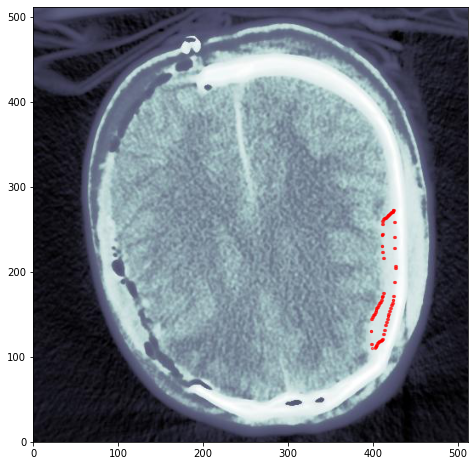

In [23]:
i = 81

photo_type = max_con
st = labels.iloc[i]['Correct Label']
coords = ast.literal_eval(st)

xys = []
for coord in coords:
    xy = [list(v.values()) for v in coord]
    xy = [[element * 512 for element in inner_list] for inner_list in xy]
    xys.append(xy)
    
print(len(xys))

img_id = labels.iloc[i]['Origin']
image_type = labels.iloc[i]['Hemorrhage Type'] + '/'

file_dir

print(file_dir + image_type + photo_type + '/' + img_id)

f, ax = plt.subplots()
f.set_size_inches(8,8)

ax.imshow(mpimg.imread(file_dir + image_type + photo_type + '/' + img_id))

# image will be flipped becasue matplotlib and cv2 have different origins (top left, bottom left)

for xy in xys:
    df = pd.DataFrame(xy)
    ax.scatter(df[0], df[1], s=5, alpha=0.5, c = 'red')
    ax.set_xlim(0, 512)
    ax.set_ylim(0, 512)

plt.show()


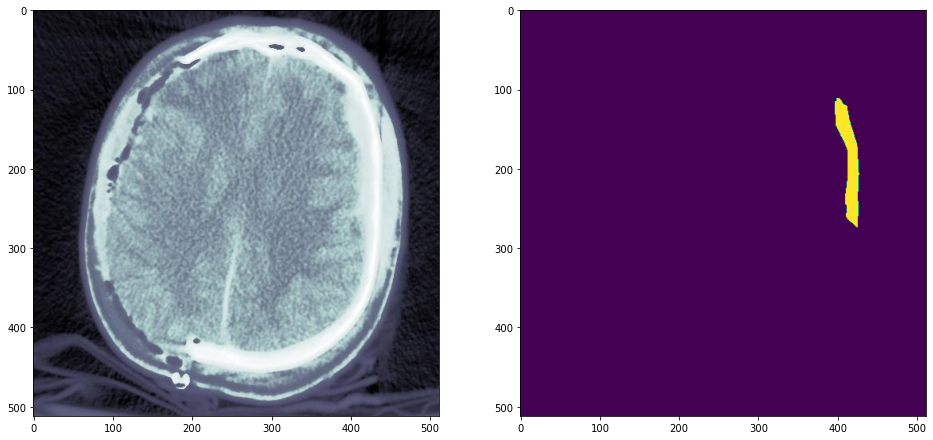

In [24]:
img = np.zeros((512, 512), dtype=np.uint8)

masks = []
for shape in xys:
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, np.int32([shape]), 255)
    masks.append(mask)

s = sum(masks)

img_orig = mpimg.imread(file_dir + image_type + photo_type + '/' + img_id)

f, ax = plt.subplots(1, 2)
f.set_size_inches(16, 8)

ax[0].imshow(img_orig)
ax[1].imshow(s)

plt.show()

**Data Aggregation**

In [25]:
import tensorflow as tf

In [26]:
seg_df = labels.filter(['Origin','Class'], axis=1)
seg_df['Mask'] = seg_df.Origin
seg_df

,Origin,Class,Mask
0,ID_004c4b319.jpg,1,ID_004c4b319.jpg
1,ID_02e2d273d.jpg,1,ID_02e2d273d.jpg
2,ID_03c6a01ca.jpg,1,ID_03c6a01ca.jpg
3,ID_045196c9f.jpg,1,ID_045196c9f.jpg
4,ID_0513bfa29.jpg,1,ID_0513bfa29.jpg
...,...,...,...
1837,ID_008bbcbc7.jpg,6,ID_008bbcbc7.jpg
1838,ID_002e03abf.jpg,6,ID_002e03abf.jpg
1839,ID_029747d7b.jpg,6,ID_029747d7b.jpg
1840,ID_0184b24fa.jpg,6,ID_0184b24fa.jpg


In [27]:
image_dataset = tf.data.Dataset.from_tensor_slices((seg_df.Origin, seg_df.Mask, seg_df.Class))
image_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [28]:
def load_and_preprocess_segmentation(image_name, mask_name, label):
    # read resize and normalize image
    image_path = 'u_net_data/images/' + image_name
    image = tf.io.read_file(image_path)
    image_decoded = tf.image.decode_jpeg(image, channels=3)
    resized_image = tf.image.resize(image_decoded, [256, 256]) / 255
    # read resize and normalize mask
    mask_path = 'u_net_data/masks/' + mask_name
    mask = tf.io.read_file(mask_path)
    mask_decoded = tf.image.decode_jpeg(mask, channels=3)
    resized_mask = tf.image.resize(mask_decoded, [256, 256]) / 255
    
    return resized_image, resized_mask, label

In [29]:
image_dataset = image_dataset.map(load_and_preprocess_segmentation).prefetch(-1)

In [30]:
# split into train and test
test_size = int(len(image_dataset) * 0.2)

image_dataset = image_dataset.shuffle(buffer_size=len(seg_df))

train_dataset = image_dataset.skip(test_size)
test_dataset = image_dataset.take(test_size)

print("Number of elements in train dataset:", len(list(train_dataset)))
print("Number of elements in test dataset:", len(list(test_dataset)))

Number of elements in train dataset: 1474
Number of elements in test dataset: 368


In [31]:
# perform a single augmentation by randomly flipping an image
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, images, masks, labels):
        inputs = self.augment_inputs(images)
        labels = self.augment_labels(masks)
        return inputs, masks, labels

In [32]:
TRAIN_LENGTH = len(list(train_dataset))
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [33]:
train_batches = (
    train_dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_dataset.batch(BATCH_SIZE)
train_batches

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

In [34]:
for x,y,z in train_batches.take(1):
    print(f"image batch size: {len(x)}, each with and image of size {len(x[0])}x{len(x[0])}")
    print(f"mask batch size: {len(y)}, each with and image of size {len(y[0])}x{len(y[0])}")
    print(f"label batch size: {len(z)}")


image batch size: 32, each with and image of size 256x256
mask batch size: 32, each with and image of size 256x256
label batch size: 32


In [35]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
        plt.show()

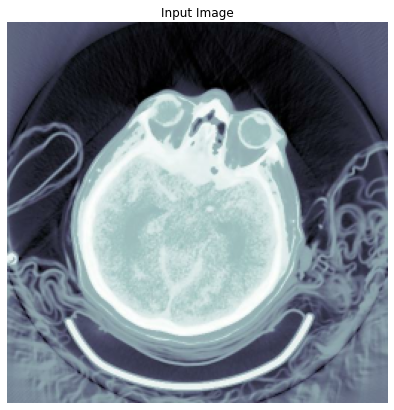

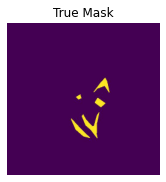

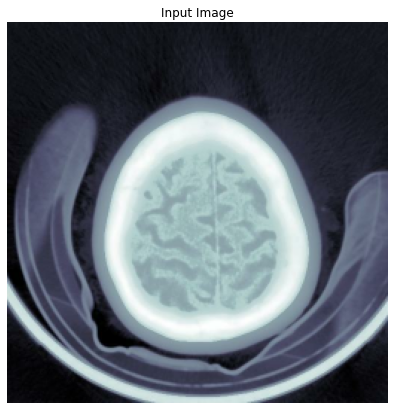

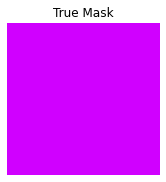

In [36]:
for images, masks, labels in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

## CNN


In [83]:
import tensorflow as tf

In [84]:
labels = load_labels(file_dir, max_con)
X, y = load_data_per_image_type(file_dir, labels, im_size)
labels.to_csv("segment.csv", index = False)

Data Shape: (1842, 262144) Label Shape: (1842,)
Image ID_88b0d8b4f.jpg is an incompatible size, skipping


In [85]:
labels = pd.read_csv('segment.csv')

In [86]:
cnn_df = labels.filter(['Origin','Class'], axis=1)
cnn_df

,Origin,Class
0,ID_004c4b319.jpg,1
1,ID_02e2d273d.jpg,1
2,ID_03c6a01ca.jpg,1
3,ID_045196c9f.jpg,1
4,ID_0513bfa29.jpg,1
...,...,...
1837,ID_008bbcbc7.jpg,6
1838,ID_002e03abf.jpg,6
1839,ID_029747d7b.jpg,6
1840,ID_0184b24fa.jpg,6


In [87]:
image_dataset = tf.data.Dataset.from_tensor_slices((cnn_df.Origin, cnn_df.Class))
image_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [88]:
def load_and_preprocess(image_name, label):
    # read resize and normalize image
    image_path = 'u_net_data/images/' + image_name
    image = tf.io.read_file(image_path)
    image_decoded = tf.image.decode_jpeg(image, channels=3)
    resized_image = tf.image.resize(image_decoded, [256, 256]) / 255
    
    return resized_image, label

In [89]:
image_dataset = image_dataset.map(load_and_preprocess).prefetch(-1)

In [90]:
n = image_dataset.cardinality().numpy()
print(n)

1842


In [94]:
# split into train and test
#'train[:80%]', 'train[80%:90%]', 'train[90%:]']

train_split1 = int(n * 0.8)
train_split2 = int(n * 0.9)

#test_size = int(len(image_dataset) * 0.2)

image_dataset = image_dataset.shuffle(buffer_size=len(seg_df))

train_dataset = image_dataset.take(train_split1)
val_dataset = image_dataset.skip(train_split1).take(train_split2 - train_split1)
test_dataset = image_dataset.skip(train_split2)

print("Number of elements in train dataset:", len(list(train_dataset)))
print("Number of elements in validation dataset:", len(list(val_dataset)))
print("Number of elements in test dataset:", len(list(test_dataset)))

Number of elements in train dataset: 1473
Number of elements in validation dataset: 184
Number of elements in test dataset: 185


In [95]:
# perform a single augmentation by randomly flipping an image
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, images, labels):
        inputs = self.augment_inputs(images)
        return inputs, labels

In [96]:
TRAIN_LENGTH = len(list(train_dataset))
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [108]:
train_batches = (
    train_dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_dataset.batch(BATCH_SIZE)

train_batches = train_dataset.batch(BATCH_SIZE).prefetch(1)
val_batches = val_dataset.batch(BATCH_SIZE).prefetch(1)
test_batches = test_dataset.batch(BATCH_SIZE).prefetch(1)

print(train_batches)
print(val_batches)
print(test_batches)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [115]:
num_classes = len(tf.unique(cnn_df.Class).y) + 1

print("Number of classes: ", num_classes)

Number of classes:  7


In [116]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, Conv2D 
from tensorflow import keras

In [117]:
input_shape = (256, 256, 3)

# Define the model
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False, input_shape= input_shape)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(num_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

 block4_sepconv1_bn (BatchNorma  (None, 32, 32, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 32, 32, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 32, 32, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 32, 32, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 16, 16, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 16, 16, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_55 (Add)                   (None, 16, 16, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_54[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 16, 16, 728)  0          ['add_55[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 16, 16, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 16, 16, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 16, 16, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 16, 16, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_58 (A

In [118]:
for layer in base_model.layers:
    layer.trainable = False


In [120]:
optimizer = tf.keras.optimizers.legacy.SGD(lr=0.01, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_batches, epochs=5, validation_data=val_batches)

Epoch 1/5
47/47 [==============================] - 103s 2s/step - loss: 2.0146 - accuracy: 0.5479 - val_loss: 1.3662 - val_accuracy: 0.5870
Epoch 2/5
47/47 [==============================] - 105s 2s/step - loss: 1.1488 - accuracy: 0.6382 - val_loss: 1.2893 - val_accuracy: 0.6250
Epoch 3/5
47/47 [==============================] - 109s 2s/step - loss: 1.1958 - accuracy: 0.6246 - val_loss: 1.0856 - val_accuracy: 0.6304
Epoch 4/5
47/47 [==============================] - 102s 2s/step - loss: 1.1124 - accuracy: 0.6375 - val_loss: 1.0004 - val_accuracy: 0.6467
Epoch 5/5
47/47 [==============================] - 102s 2s/step - loss: 1.0389 - accuracy: 0.6606 - val_loss: 1.0329 - val_accuracy: 0.6522


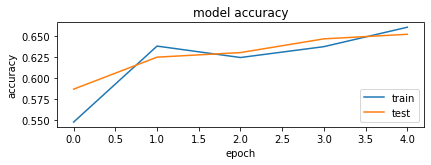

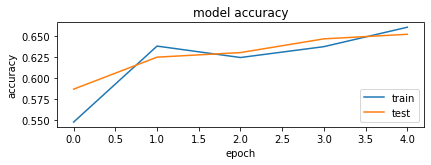

In [122]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.tight_layout()

fig